<a href="https://colab.research.google.com/github/mkuczynski11/pug-project/blob/main/PUG_Dry_Run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

### Tensorboard and HParams setup

In [1]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboarda

In [4]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

### Setup training and validation datasets

In [5]:
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 50
IMG_HEIGHT = 128
IMG_WIDTH = 128
DENSE_LAYER_ACTIVATION = 'softmax'
CLASS_MODE='categorical'
OBJECTIVE_FUNCTION='categorical_crossentropy'
LOSS_METRICS=['accuracy']
EPOCHS = 50
EARLY_STOP_PATIENCE = 3
STEPS_PER_EPOCH_TRAINING = 10
# Use ready cnn architecture to detect image features
CNN_FEATURE_VECTOR = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/feature_vector/5"

In [6]:
# Usage of google drive where we are storing our data
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = '/content/gdrive/MyDrive/PUG/garbage_classification' # directory of your data
!rm -rf /content/gdrive/MyDrive/PUG/garbage_classification/.ipynb_checkpoints/

Mounted at /content/gdrive


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    validation_split=0.2
)

In [8]:
train_ds = data_generator.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_TRAINING,
    class_mode=CLASS_MODE
)

Found 15515 images belonging to 12 classes.


In [9]:
val_ds = data_generator.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode=CLASS_MODE,
    subset='validation'
)

Found 3100 images belonging to 12 classes.


In [ ]:
class_names = []
for key in train_ds.class_indices.keys():
  class_names.append(key)

print(class_names)


['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


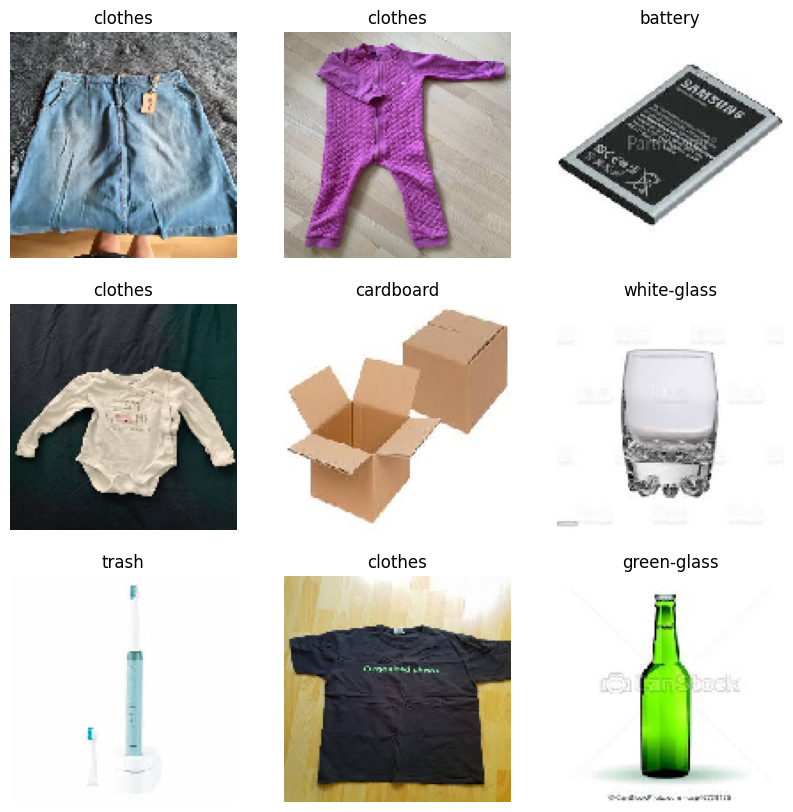

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(train_ds[0][0][i].astype('uint8'))
  index = np.argmax(train_ds[0][1][i])
  plt.title(class_names[index])
  plt.axis("off")

### Define model

In [ ]:
import tensorflow_hub as hub

num_classes = train_ds.num_classes

# Name model with used architecture
model_name = CNN_FEATURE_VECTOR.split('/')[5]
model_dir = pathlib.Path(f'/content/models/{model_name}')
model_dir.mkdir(exist_ok=True, parents=True)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))
model.add(hub.KerasLayer(CNN_FEATURE_VECTOR, trainable=False))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(96, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(num_classes, activation=DENSE_LAYER_ACTIVATION))

In [ ]:
# print how model looks
model.summary()

In [ ]:
from tensorflow.keras import optimizers

model.compile(optimizer='adam',
              loss=OBJECTIVE_FUNCTION,
              metrics=LOSS_METRICS)

### Train model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOP_PATIENCE
)

base_model_path = 'model.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    base_model_path,
    save_best_only=True
)


In [ ]:
model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)
# Also add epochs that model has been trained on
import sys
original_stdout = sys.stdout # Save a reference to the original standard output
with open(f'{model_dir}/{model_name}.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    model.summary()
    sys.stdout = original_stdout # Reset the standard output to its original value

Epoch 1/50
10/10 [==============================] - 2321s 251s/step - loss: 2.0347 - accuracy: 0.3550 - val_loss: 1.5457 - val_accuracy: 0.5235
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 445s 45s/step - loss: 1.0800 - accuracy: 0.7020 - val_loss: 1.0178 - val_accuracy: 0.7090
Epoch 3/50
10/10 [==============================] - 446s 45s/step - loss: 0.7690 - accuracy: 0.8150 - val_loss: 0.8120 - val_accuracy: 0.7700
Epoch 4/50
10/10 [==============================] - 371s 38s/step - loss: 0.6986 - accuracy: 0.8190 - val_loss: 0.6746 - val_accuracy: 0.8074
Epoch 5/50
10/10 [==============================] - 356s 35s/step - loss: 0.5557 - accuracy: 0.8750 - val_loss: 0.5717 - val_accuracy: 0.8371
Epoch 6/50
10/10 [==============================] - 326s 32s/step - loss: 0.5119 - accuracy: 0.8830 - val_loss: 0.5032 - val_accuracy: 0.8568
Epoch 7/50
10/10 [==============================] - 315s 32s/step - loss: 0.4943 - accuracy: 0.8890 - val_loss: 0.4555 - val_accuracy: 0.8677
Epoch 8/50
10/10 [==============================] - 313s 31s/step - loss: 0.4677 - accuracy: 0.8880 - val_loss: 0.4203 - val_accuracy: 0.8787
Epoch 9/50
10/10 

### Check accuracy

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f'loss={loss}, accuracy={acc}')

31/31 [==============================] - 8s 271ms/step - loss: 0.0984 - accuracy: 0.9761
loss=0.09839139878749847, accuracy=0.9761290550231934
